# 202_6.2_行動数_2_s-learner.ipynb

## 6.2 プラットフォーム全体で観測される報酬を最適化する方策学習

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

from dataset import generate_synthetic_data2
from policylearners import IPSBasedGradientPolicyLearner, CateBasedGradientPolicyLearner
from utils import softmax

import math
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor

### ログデータ(トレーニングデータ)のサイズ$n$を変化させたときの方策性能の変化

In [2]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数
dim_x = 5 # 特徴量xの次元
num_actions = 10 # 行動数, |A|
beta = -0.1 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_actions_list = [2, 10] # 行動数
num_data_list = [100, 500, 1000, 2000] # トレーニングデータのサイズ

In [3]:
num_actions = num_actions_list[0]
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))
## 学習された方策の真の性能を近似するためのテストデータを生成
test_data = generate_synthetic_data2(
    num_data=test_data_size, beta=beta,
    theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
    dim_context=dim_x, num_actions=num_actions, random_state = random_state
)
pi_0, q_x_a_1, q_x_a_0 = test_data["pi_0"], test_data["q_x_a_1"], test_data["q_x_a_0"]
pi_0_value = (pi_0 * q_x_a_1 + (1. - pi_0) * q_x_a_0).sum(1).mean()

In [4]:
num_data = num_data_list[3]
test_policy_value_list = []
_ = 0

## データ収集方策が形成する分布に従いログデータを生成
offline_logged_data = generate_synthetic_data2(
    num_data=num_data, beta=beta,
    theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
    dim_context=dim_x, num_actions=num_actions, random_state = _
)

true_value_of_learned_policies = dict()
true_value_of_learned_policies["logging"] = pi_0_value

## ログデータを用いてオフ方策学習を実行する
### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
ips = IPSBasedGradientPolicyLearner(
    dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
)
ips.fit(offline_logged_data, test_data)
pi_ips = ips.predict(test_data)
true_value_of_learned_policies["ips-pg"] = (pi_ips * q_x_a_1 + (1 - pi_ips) * q_x_a_0).sum(1).mean()
ips_pg = (pi_ips * q_x_a_1 + (1 - pi_ips) * q_x_a_0).sum(1).mean()
### 勾配ベースのアプローチ (新たに開発した推定量で方策勾配を推定)
cate = CateBasedGradientPolicyLearner(
    dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
)
cate.fit(offline_logged_data, test_data)
pi_cate = cate.predict(test_data)
true_value_of_learned_policies["cate-pg"] = (pi_cate * q_x_a_1 + (1 - pi_cate) * q_x_a_0).sum(1).mean()
cate_pg = (pi_cate * q_x_a_1 + (1 - pi_cate) * q_x_a_0).sum(1).mean()

test_policy_value_list.append(true_value_of_learned_policies)

## 各方策・報酬期待値理解
### 旧方策

In [5]:
print(f'旧方策報酬: {pi_0_value:.3f}')

旧方策報酬: 0.487


### IPS(勾配)

In [6]:
print(f'IPS(勾配)による方策報酬: {ips_pg:.3f}')

IPS(勾配)による方策報酬: 0.163


### Newによる方策報酬

In [7]:
print(f'Newによる方策報酬: {cate_pg:.3f}')

Newによる方策報酬: 3.135


## ここから佐々木の方で方策学習を行い、それによる報酬期待値を得る
### ちなみにランダムで推薦アイテムを決めた場合の期待報酬を計算してみる

In [8]:
pi_random = np.full((50000, num_actions), 1/num_actions)
radom_pg = (pi_random * q_x_a_1 + (1 - pi_random) * q_x_a_0).sum(1).mean()
print(f'ランダム割り当てによる方策報酬: {radom_pg:.3f}')

ランダム割り当てによる方策報酬: 1.287


(まさかのIPS以上New未満...)

### s-learnerでやってみる

In [9]:
# データ整形: 観測される情報のみを持つDataFrameを生成する
x = offline_logged_data['x']
a = offline_logged_data['a']
r = offline_logged_data['r']
combined = np.hstack([x, a.reshape(-1, 1), r.reshape(-1, 1)])

# データフレームに変換
df = pd.DataFrame(combined, columns=[
    'x_0',
    'x_1',
    'x_2',
    'x_3',
    'x_4',
    'a',
    'r'
])
df

,x_0,x_1,x_2,x_3,x_4,a,r
0,1.764052,0.400157,0.978738,2.240893,1.867558,0.0,-3.346168
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,1.0,-1.495503
2,0.144044,1.454274,0.761038,0.121675,0.443863,1.0,1.337019
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,1.0,2.315102
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,1.0,-1.731061
...,...,...,...,...,...,...,...
1995,0.224821,-1.038472,0.771819,-0.480009,1.834745,1.0,0.324212
1996,-0.108765,0.454475,0.098709,-0.458305,-0.857044,1.0,-3.360536
1997,-0.774403,0.708787,0.018474,-0.104081,-0.234858,0.0,1.004499
1998,-0.250906,-0.962750,0.493405,2.133050,0.983888,1.0,-2.053208


In [10]:
# 説明変数: x0〜x4 + a（処置変数）
feature_cols = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'a']
X = df[feature_cols]
y = df['r']  # 目的変数

# 学習
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [11]:
# testデータをデータフレームに変換
test_data_df = pd.DataFrame(test_data['x'], columns=[
    'x_0',
    'x_1',
    'x_2',
    'x_3',
    'x_4',
])
test_data_df_list = []
for a in range(num_actions):
    tmp_test_data_df = test_data_df.copy()
    tmp_test_data_df['a'] = a
    test_data_df_list.append(tmp_test_data_df)
display(test_data_df_list[0].head())
display(test_data_df_list[1].head())

,x_0,x_1,x_2,x_3,x_4,a
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,0
1,1.393406,0.092908,0.281746,0.769023,1.246435,0
2,1.007189,-1.296221,0.274992,0.228913,1.352917,0
3,0.886429,-2.001637,-0.371843,1.669025,-0.438570,0
4,-0.539741,0.476985,3.248944,-1.021228,-0.577087,0


,x_0,x_1,x_2,x_3,x_4,a
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,1
1,1.393406,0.092908,0.281746,0.769023,1.246435,1
2,1.007189,-1.296221,0.274992,0.228913,1.352917,1
3,0.886429,-2.001637,-0.371843,1.669025,-0.438570,1
4,-0.539741,0.476985,3.248944,-1.021228,-0.577087,1


In [12]:
for a in range(num_actions):
    test_data_df[f'r_hat_{a}'] = model.predict(test_data_df_list[a][['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'a']])
test_data_df['uplift_r_hat'] = test_data_df['r_hat_1'] - test_data_df['r_hat_0']
test_data_df

,x_0,x_1,x_2,x_3,x_4,r_hat_0,r_hat_1,uplift_r_hat
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,5.679499,-1.943560,-7.623059
1,1.393406,0.092908,0.281746,0.769023,1.246435,2.853402,-3.100100,-5.953502
2,1.007189,-1.296221,0.274992,0.228913,1.352917,2.722208,0.406896,-2.315312
3,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-3.893530,-2.112685,1.780844
4,-0.539741,0.476985,3.248944,-1.021228,-0.577087,13.894875,13.667827,-0.227048
...,...,...,...,...,...,...,...,...
49995,-1.502279,0.338190,-0.573258,-0.377969,-1.742207,-1.428479,-4.118508,-2.690030
49996,-0.238790,0.361659,0.050803,1.136654,-1.520213,-1.562017,-3.924873,-2.362856
49997,0.111191,1.349551,-0.887112,1.432936,-0.347411,-2.833996,-2.327073,0.506923
49998,0.438447,0.399579,-0.526843,0.779586,-1.400417,0.234203,-3.482636,-3.716839


<Axes: >

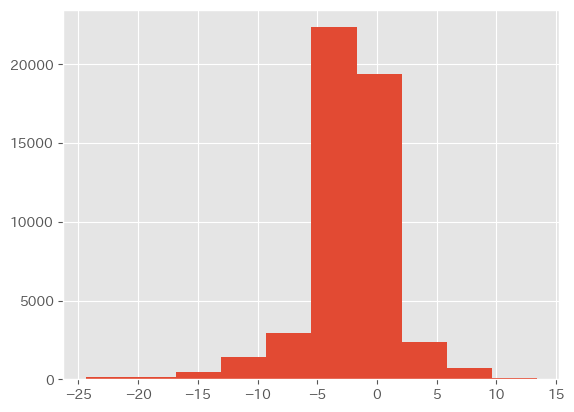

In [13]:
test_data_df['uplift_r_hat'].hist()

In [29]:
# 元のインデックスを保ったまま、uplift_r_hatの順位を取る
ranks = test_data_df['uplift_r_hat'].rank(method='first', ascending=False)

# 全データ数
n = len(test_data_df)

# ランクに応じてグループ（0〜8）を割り振り
group = (ranks / n * 9).astype(int).clip(upper=8)  # 0〜8の整数にする

# pi_sasaken_0を設定（グループ番号+1）/10
test_data_df['pi_sasaken_0'] = (group + 1) / 10

test_data_df['pi_sasaken_1'] = 1 - test_data_df['pi_sasaken_0']
pi_sasaken = test_data_df[['pi_sasaken_0', 'pi_sasaken_1']]
pi_sasaken[0:5]

,pi_sasaken_0,pi_sasaken_1
0,0.9,0.1
1,0.9,0.1
2,0.6,0.4
3,0.1,0.9
4,0.2,0.8


In [28]:
# 報酬期待値を計算
sasaken_pg = (pi_sasaken * q_x_a_1 + (1 - pi_sasaken) * q_x_a_0).sum(1).mean()
print(f'ささけん割り当てによる方策報酬: {sasaken_pg:.3f}')

ささけん割り当てによる方策報酬: 1.178


旧方策・IPS以上ランダム未満、まだまだかな、、、